# GlobalOQA Results Analysis

This notebook analyzes evaluation results in `globaloqa/results/`.

- **Personas**: countries (e.g. `Britain`, `Germany`, ...)
- **Config**: edit `PERSONAS_TO_SHOW` to control the x-axis ordering/filtering (defaults to all countries).

In [1]:
# Analysis of evaluation results in `results/`

from pathlib import Path
import json
from dataclasses import dataclass
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path.cwd() / "results"

# X-axis personas (countries) to show (edit this list as needed)
PERSONAS_TO_SHOW = [
    "Brazil",
    "Britain",
    "France",
    "Germany",
    "Indonesia",
    "Japan",
    "Jordan",
    "Lebanon",
    "Mexico",
    "Nigeria",
    "Pakistan",
    "Russia",
    "Turkey",
]

In [2]:
# Filename pattern: eval_results_{condition1}_{condition2}_{modelnickname}_{persona}.jsonl

@dataclass
class ResultMeta:
    path: Path
    condition1: str
    condition2: str
    model_nickname: str
    persona: str


def parse_filename(path: Path) -> ResultMeta:
    name = path.stem  # no extension
    assert name.startswith("eval_results_"), f"Unexpected filename: {name}"
    parts = name[len("eval_results_"):].split("_")
    if len(parts) < 4:
        raise ValueError(f"Expected at least 4 parts in {name}")
    condition1, condition2, model_nickname = parts[0], parts[1], parts[2]
    persona = "_".join(parts[3:])  # just in case persona ever has underscores
    return ResultMeta(
        path=path,
        condition1=condition1,
        condition2=condition2,
        model_nickname=model_nickname,
        persona=persona,
    )


# Each line: JSON with fields including `label` (0/1) and model key (e.g. "deepseek/deepseek-r1-0528": true/false).
# For accuracy, we treat each *question_id* as one item: a question is counted
# as correct only if *all* options for that question_id are predicted correctly.

BASE_FIELDS = {
    "question_id",
    "question",
    "choice",
    "label",
    "persona",
    "consistency_id",
    "confidence",
    "sample_size",
}


def detect_model_key(sample_record: dict) -> str:
    keys = [k for k in sample_record.keys() if k not in BASE_FIELDS]
    if not keys:
        raise ValueError(f"No model key found in record: {sample_record}")
    if len(keys) > 1:
        keys.sort()
    return keys[0]


def compute_accuracy(path: Path) -> dict:
    """Compute accuracy at the question level.

    A question (identified by question_id) is correct only if the model gets
    *all* its options right (e.g. both answer choices for that question).
    """
    meta = parse_filename(path)
    model_key = None
    records = []

    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if model_key is None:
                model_key = detect_model_key(rec)
            records.append(rec)

    if model_key is None:
        raise ValueError(f"No data found in {path}")

    by_qid = {}
    for rec in records:
        qid = rec["question_id"]
        by_qid.setdefault(qid, []).append(rec)

    total_q = 0
    correct_q = 0

    for qid, group in by_qid.items():
        total_q += 1
        all_correct = True
        for rec in group:
            label = bool(rec["label"])  # 1 == True, 0 == False
            pred = bool(rec[model_key])
            if pred != label:
                all_correct = False
                break
        if all_correct:
            correct_q += 1

    acc = correct_q / total_q if total_q else 0.0
    return {
        "path": str(path),
        "condition1": meta.condition1,
        "condition2": meta.condition2,
        "condition": f"{meta.condition1}_{meta.condition2}",
        "model_nickname": meta.model_nickname,
        "persona": meta.persona,
        "model_key": model_key,
        "n": total_q,
        "correct": correct_q,
        "accuracy": acc,
    }

In [3]:
# Load all result files and compute accuracies

all_files: List[Path] = sorted(RESULTS_DIR.glob("eval_results_*.jsonl"))
print(f"Found {len(all_files)} result files.")

rows = [compute_accuracy(p) for p in all_files]
summary_df = pd.DataFrame(rows)
summary_df

Found 52 result files.


,path,condition1,condition2,condition,model_nickname,persona,model_key,n,correct,accuracy
0,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Brazil,anthropic/claude-3.5-haiku,16,13,0.812500
1,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Britain,anthropic/claude-3.5-haiku,28,17,0.607143
2,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,France,anthropic/claude-3.5-haiku,28,16,0.571429
3,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Germany,anthropic/claude-3.5-haiku,28,12,0.428571
4,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Indonesia,anthropic/claude-3.5-haiku,23,11,0.478261
5,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Japan,anthropic/claude-3.5-haiku,28,14,0.500000
6,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Jordan,anthropic/claude-3.5-haiku,28,11,0.392857
7,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Lebanon,anthropic/claude-3.5-haiku,28,13,0.464286
8,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Mexico,anthropic/claude-3.5-haiku,28,14,0.500000
9,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,Nigeria,anthropic/claude-3.5-haiku,15,4,0.266667


C:\Users\G25971483\AppData\Local\Temp\ipykernel_35564\3202697001.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(conditions))


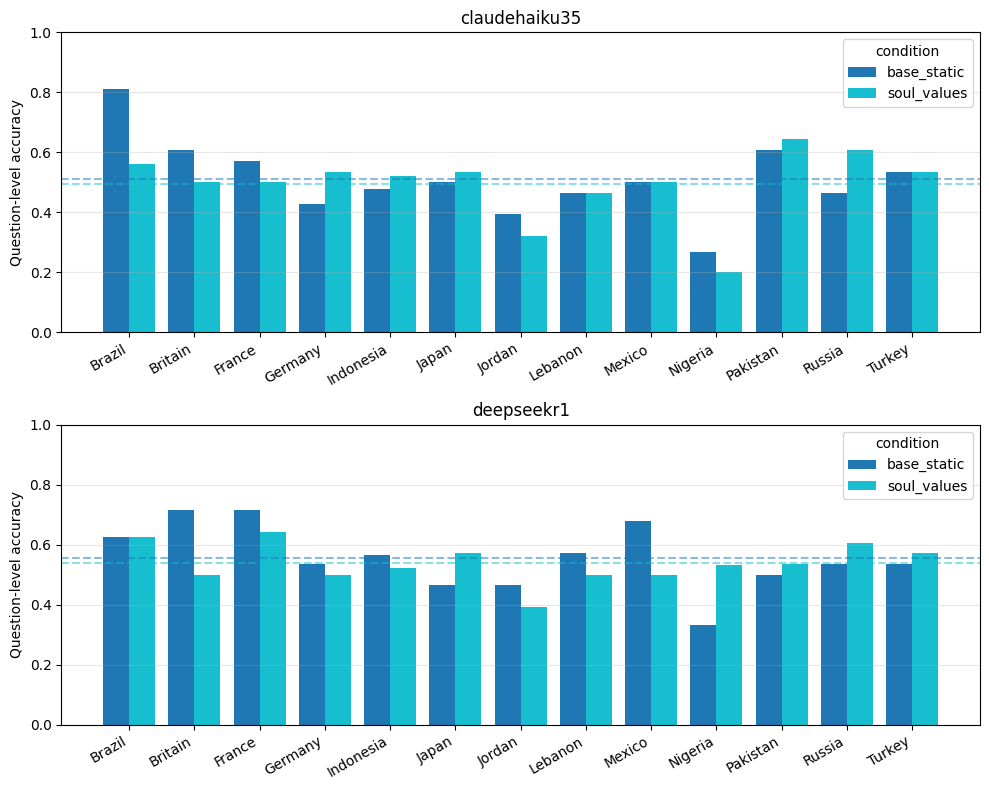

In [4]:
# Plot: rows = models, x-axis personas (countries), colors = conditions.

def plot_accuracy(df: pd.DataFrame, personas: List[str] | None = None) -> None:
    if personas is None:
        personas = PERSONAS_TO_SHOW

    # Keep only requested personas (case-insensitive)
    wanted = {p.lower() for p in personas}
    df = df[df["persona"].str.lower().isin(wanted)].copy()

    conditions = sorted(df["condition"].unique())
    models = sorted(df["model_nickname"].unique())

    n_models = len(models)
    fig, axes = plt.subplots(
        n_models,
        1,
        figsize=(max(10, len(personas) * 0.7), 4 * n_models),
        sharey=True,
    )
    if n_models == 1:
        axes = [axes]

    cmap = plt.cm.get_cmap("tab10", len(conditions))

    for ax, model in zip(axes, models):
        sub = df[df["model_nickname"] == model]

        x_positions = list(range(len(personas)))
        total_width = 0.8
        bar_w = total_width / max(1, len(conditions))
        offsets = [(-total_width / 2) + (i + 0.5) * bar_w for i in range(len(conditions))]

        # Bars per condition
        cond_means: dict[str, float] = {}
        for c_i, cond in enumerate(conditions):
            ys = []
            for persona in personas:
                row = sub[(sub["persona"].str.lower() == persona.lower()) & (sub["condition"] == cond)]
                ys.append(row["accuracy"].iloc[0] if len(row) else None)

            xs = [x + offsets[c_i] for x in x_positions]
            ax.bar(
                xs,
                [y if y is not None else 0.0 for y in ys],
                width=bar_w,
                color=cmap(c_i),
                label=cond,
            )

            # Average accuracy over shown personas for this condition
            valid_vals = [y for y in ys if y is not None]
            if valid_vals:
                cond_means[cond] = sum(valid_vals) / len(valid_vals)

        # Add horizontal dotted lines for each condition's average
        for c_i, cond in enumerate(conditions):
            if cond not in cond_means:
                continue
            ax.axhline(
                cond_means[cond],
                color=cmap(c_i),
                linestyle="--",
                linewidth=1.5,
                alpha=0.5,
                label=None,
            )

        ax.set_title(model)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(personas, rotation=30, ha="right")
        ax.set_ylim(0, 1)
        ax.set_ylabel("Question-level accuracy")
        ax.grid(axis="y", alpha=0.3)
        ax.legend(title="condition")

    plt.tight_layout()
    plt.show()


plot_accuracy(summary_df)